<a href="https://colab.research.google.com/github/miguel-mb-cell/Traffic-Sign-YOLO11/blob/main/Detec%C3%A7%C3%A3o_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Imagens com YOLO


## Objetivos

Vamos treinar o modelo de estado da arte YOLO (You Only Look Once) v 11, para reconhecer placas de trânsito, usando um dataset do roboflow.

## Setup
Primeiro, muito importante, é necessário selecionar o GPU do Colab para acelerar o treinamento do modelo, usando CPU iria demorar demasiadamente.

Vamos usar o GPU do Colab. Navegue para `Tempo de execução` -> `Alterar tipo de tempo de execução` -> `Acelerador de hardware` -> e selecione `GPU`.

O comando abaixo deve mostrar uma tabela indicando o GPU.

In [ ]:
!nvidia-smi

Mon Dec 16 17:33:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Para facilitar a navegação pelo dataset, vamos configurar a variável global HOME.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Dataset
A plataforma Roboflow oferece uma variedade de ferramentas para gerenciar conjuntos de dados, anotar imagens e treinar modelos poderosos. Ela possui diversos datasets e projetos já prontos.

Para usar um dataset do Roboflow, é necessário configurar a chave de API da sua conta do Roboflow nos `Secrets` do Colab:

- Vá para [Roboflow Settings](https://app.roboflow.com/settings/api). Copie sua "`Private API Key`".
- No Colab, no menu larteral na esquerda, clique em "`Secrets`". Adicione um novo segredo com o nome "`ROBOFLOW_API_KEY`" e o valor com a chave que você copiou do Roboflow.

Feito isso, vamos baixar nosso dataset. É necessário que ele fique dentro de uma pasta chamada `dataset`.

In [ ]:
import os

# Criar o diretório se ele não existir
os.makedirs('datasets', exist_ok=True)

%cd {HOME}/datasets

/content/datasets


Vamos importar o roboflow para acessar o dataset e o userdata para acessar dados do usuário.

In [ ]:
%pip install roboflow

from google.colab import userdata
from roboflow import Roboflow

E configurar o roboflow para acessar o dataset com a chave de API.

In [ ]:
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("ensa-tetouan-1z28i").project("taher-rhbiy")
version = project.version(11)

dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to taher-11 in yolov11:: 100%|██████████| 19350/19350 [00:02<00:00, 7064.43it/s]


A rede YOLO cria uma pasta chamada runs, para salvar os dados sobre treinamentos, validações e previsões executada. Dessa forma, vamos executar o seguinte comando para que essa pasta fique na raiz.

In [ ]:
%cd {HOME}

/content


## YOLO11
A YOLOv11 é a versão mais recente da renomada família de redes de detecção de objetos YOLO (You Only Look Once), desenvolvida pela Ultralytics. Com foco em eficiência e precisão, a YOLOv11 traz inovações significativas em relação às versões anteriores, como YOLOv8, YOLOv9 e YOLOv10.

A arquitetura desta nova versão foi projetada para otimizar tanto a velocidade quanto a precisão, incorporando avanços como o bloco **C3K2**, o módulo **SPFF** (Spatial Pyramid Pooling Fast) e o bloco **C2PSA** (Cross Stage Partial with Spatial Attention). Essas melhorias tornam a YOLOv11 altamente eficiente para tarefas de detecção de objetos em tempo real, ao mesmo tempo que aumenta sua capacidade de lidar com pequenos detalhes e escalas variadas.

Vamos dar uma olhada em sua arquitetura e as inovações que essa versão trouxe!

### Arquitetura

#### 1. Backbone (Espinha Dorsal)
O backbone é responsável por extrair os recursos básicos da imagem de entrada e inclui os seguintes componentes:

##### a. Bloco de Convolução (Conv Block)
- Consiste em uma camada de convolução 2D, seguida por normalização em lote (Batch Normalization) e uma função de ativação **SiLU** (também conhecida como Sigmoid Linear Unit).
- **SiLU** é mais eficiente do que a ativação sigmoid tradicional, pois combina suavidade e não linearidade, sendo mais adequado para aprendizado profundo.

##### b. Bottle Neck (Gargalo)
- Inspirado no ResNet, o **Bottle Neck** usa conexões residuais para preservar informações importantes.
- Se o parâmetro **shortcut** for desativado, não será considerada a conexão residual.

##### c. C2F (Cross Stage Partial Focus)
- Introduzido no YOLOv8, divide a saída de um bloco em dois caminhos (metade dos canais).
- Um caminho passa por várias camadas de **Bottle Neck**, enquanto o outro é conectado diretamente.
- No final, todos os caminhos são concatenados, melhorando a preservação de informações com eficiência computacional.

##### d. C3K2
- O **C3K2** é uma evolução do bloco CSP. Ele usa kernels menores (3x3) para reduzir a complexidade computacional sem sacrificar a precisão.
- Esse bloco começa com dois **Conv Blocks**, passa por uma série de blocos C3K e termina concatenando a saída final com a entrada original.

###### Comparação entre C2F e C3K2:
- **C2F**: Divide os canais da entrada e os processa separadamente.
- **C3K2**: Processa toda a entrada diretamente, usando convoluções menores para economizar recursos.

---

#### 2. Neck (Pescoço)
A função do pescoço é reunir informações de diferentes escalas da imagem e conectar o backbone à cabeça de detecção.

##### a. SPFF (Spatial Pyramid Pooling Fast)
- É uma melhoria do módulo de pooling em pirâmide (SPP) das versões anteriores.
- Combina informações em múltiplas escalas usando operações de pooling máximo com diferentes tamanhos de kernel.
- Esse módulo melhora a detecção de objetos pequenos e objetos em diferentes resoluções sem comprometer a velocidade.

---

#### 3. Mecanismos de Atenção: C2PSA Block
O bloco **C2PSA** aprimora o foco do modelo em regiões importantes da imagem. Ele é composto pelos seguintes elementos:

##### a. PSA (Partial Spatial Attention)
- Aplica atenção espacial para destacar regiões relevantes da imagem, como objetos pequenos ou parcialmente ocultos.
- Inclui processamento inicial com atenção espacial, seguido por redes neurais feed-forward e blocos de convolução.

##### b. C2PSA (Cross Stage Partial with Spatial Attention)
- Utiliza dois módulos PSA em caminhos separados.
- Após processar os dois caminhos, suas saídas são concatenadas, como na estrutura do C2F.
- Esse bloco refina a capacidade de YOLOv11 de focar seletivamente em regiões relevantes, especialmente em objetos pequenos e com detalhes finos.

---

#### 4. Head (Cabeça de Detecção)
A cabeça do YOLOv11 é responsável por prever caixas delimitadoras e classes de objetos em diferentes escalas. Ela usa três níveis de granularidade:
- **P3**: Detecção de objetos pequenos com detalhes mais refinados.
- **P4**: Objetos médios.
- **P5**: Detecção de objetos grandes usando recursos de alto nível.

Cada nível recebe informações de diferentes partes do **backbone** e do **neck**, garantindo que o modelo seja capaz de detectar objetos de diversos tamanhos de forma eficiente.

---

#### Resumo das Inovações
1. **C3K2 Block**: Usa convoluções menores (3x3) para melhorar a eficiência, reduzindo a redundância de informações.
2. **SPFF**: Agrega informações em diferentes escalas, melhorando a detecção de objetos pequenos sem comprometer a velocidade.
3. **C2PSA Block**: Introduz atenção espacial para dar foco às regiões mais importantes da imagem, como pequenos detalhes.

Essas melhorias tornam o YOLOv11 uma rede poderosa e eficiente para tarefas de detecção de objetos, superando versões anteriores em precisão e velocidade.


Visto isso, vamos à implementação!
Primeiro, vamos instalar a biblioteca da Ultralytics.

In [ ]:
%pip install "ultralytics<=8.3.40"
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.1/112.6 GB disk)


### Treinamento
Agora, podemos importar o modelo YOLO e declarar um modelo pré-treinado, com pesos e parâmetros otimizados para tarefas gerais de detecção de objetos.

Dessa forma, o **Transfer Learning** ocorre de maneira **implícita**.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO("yolo11n.pt")

model.train(data=f"{dataset.location}/data.yaml", epochs=20, imgsz=640, task='detect', plots=True)

New https://pypi.org/project/ultralytics/8.3.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/taher-11/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning /content/datasets/taher-11/train/labels.cache... 6923 images, 5011 backgrounds, 0 corrupt: 100%|██████████| 6923/6923 [00:00<?, ?it/s]


WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4, len(boxes) = 2010. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/taher-11/valid/labels.cache... 1841 images, 1486 backgrounds, 0 corrupt: 100%|██████████| 1841/1841 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.47G      0.992      3.437      1.407          3        640: 100%|██████████| 433/433 [02:34<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:15<00:00,  3.81it/s]


                   all       1841        368       0.52      0.447      0.453      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.41G      1.159      2.094      1.526          2        640: 100%|██████████| 433/433 [02:30<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:14<00:00,  4.00it/s]


                   all       1841        368      0.129       0.42       0.19      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.4G      1.174      1.678      1.521          7        640: 100%|██████████| 433/433 [02:24<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:14<00:00,  4.07it/s]

                   all       1841        368      0.323      0.498      0.358      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.38G      1.092      1.545      1.456          7        640: 100%|██████████| 433/433 [02:21<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:14<00:00,  4.14it/s]

                   all       1841        368      0.256      0.675      0.343      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.38G      1.052      1.363      1.419          7        640: 100%|██████████| 433/433 [02:22<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]

                   all       1841        368      0.349      0.708      0.461      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.39G     0.9614      1.228      1.351          6        640: 100%|██████████| 433/433 [02:29<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:15<00:00,  3.71it/s]

                   all       1841        368      0.407      0.659      0.458      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G      0.946      1.187      1.346         12        640: 100%|██████████| 433/433 [02:29<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]


                   all       1841        368      0.478      0.643      0.546      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.38G      0.906      1.077      1.324         11        640: 100%|██████████| 433/433 [02:30<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.90it/s]

                   all       1841        368      0.706      0.535      0.677      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.38G     0.8903      1.057      1.312         10        640: 100%|██████████| 433/433 [02:23<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  5.04it/s]

                   all       1841        368      0.809       0.69      0.797      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.39G     0.8904      1.015      1.293          8        640: 100%|██████████| 433/433 [02:27<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  5.11it/s]

                   all       1841        368      0.814      0.721      0.811      0.657


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.47G     0.8217     0.8839      1.366          2        640: 100%|██████████| 433/433 [02:21<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.38it/s]

                   all       1841        368      0.739      0.783      0.801      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.38G     0.8056     0.8026      1.342          5        640: 100%|██████████| 433/433 [02:16<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]

                   all       1841        368      0.773      0.799      0.847      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.38G     0.7718     0.7638      1.321          4        640: 100%|██████████| 433/433 [02:18<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.25it/s]

                   all       1841        368       0.83      0.731      0.819       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.39G     0.7533     0.6753      1.306          4        640: 100%|██████████| 433/433 [02:16<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1841        368      0.744      0.741       0.76      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.4G     0.7109     0.6639      1.255          4        640: 100%|██████████| 433/433 [02:17<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.38it/s]

                   all       1841        368      0.791      0.857      0.855      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.38G     0.7285     0.6174      1.278          5        640: 100%|██████████| 433/433 [02:18<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  5.03it/s]

                   all       1841        368      0.817      0.705      0.772       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.38G     0.6984     0.6056      1.259          3        640: 100%|██████████| 433/433 [02:18<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]


                   all       1841        368      0.819      0.782      0.843      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.39G      0.687     0.5657      1.232          2        640: 100%|██████████| 433/433 [02:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.42it/s]

                   all       1841        368      0.798      0.829      0.852      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.4G     0.6591     0.5254      1.207          3        640: 100%|██████████| 433/433 [02:23<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:10<00:00,  5.34it/s]

                   all       1841        368      0.849       0.72      0.814      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.38G     0.6745     0.5174       1.22          5        640: 100%|██████████| 433/433 [02:21<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.27it/s]

                   all       1841        368      0.873      0.722      0.857      0.734



20 epochs completed in 0.877 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.21it/s]


                   all       1841        368      0.872      0.722      0.857      0.734
        speed_limit_60        157        157      0.837      0.624      0.821      0.712
        speed_limit_80        203        211      0.908       0.82      0.893      0.757
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fbe791f85b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### Validação
O modelo foi treinado com o dataset, agora vamos ver como ele se saiu.

In [ ]:
metrics = model.val(data=f"{dataset.location}/data.yaml")

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/datasets/taher-11/valid/labels.cache... 1841 images, 1486 backgrounds, 0 corrupt: 100%|██████████| 1841/1841 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [00:16<00:00,  7.18it/s]


                   all       1841        368      0.845      0.744      0.855      0.735
        speed_limit_60        157        157      0.831      0.658      0.818      0.711
        speed_limit_80        203        211       0.86      0.829      0.891      0.759
Speed: 0.3ms preprocess, 4.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train32


Vamos ver a métrica **mAP (mean Avarage Precision)**, que é a média de precisão média. Essa métrica nos dá uma visão geral da performance do modelo em todas as classes de objetos.

In [ ]:
map_50_95 = metrics.box.map
print(f"MAP50-95: {map_50_95}")

MAP50-95: 0.7349312366901696


Alcançou **73%** de acurácia geral, o que é um excelente resultado, considerando o quão breve foi o desenvolvimento desse estudo.

Podemos também carregar um lote de imagens que foi usado para a validação do modelo.

Essas imagens foram separadas no dataset e não foram usadas durante o treinamento, ou seja, são imagens completamente novas para o modelo.

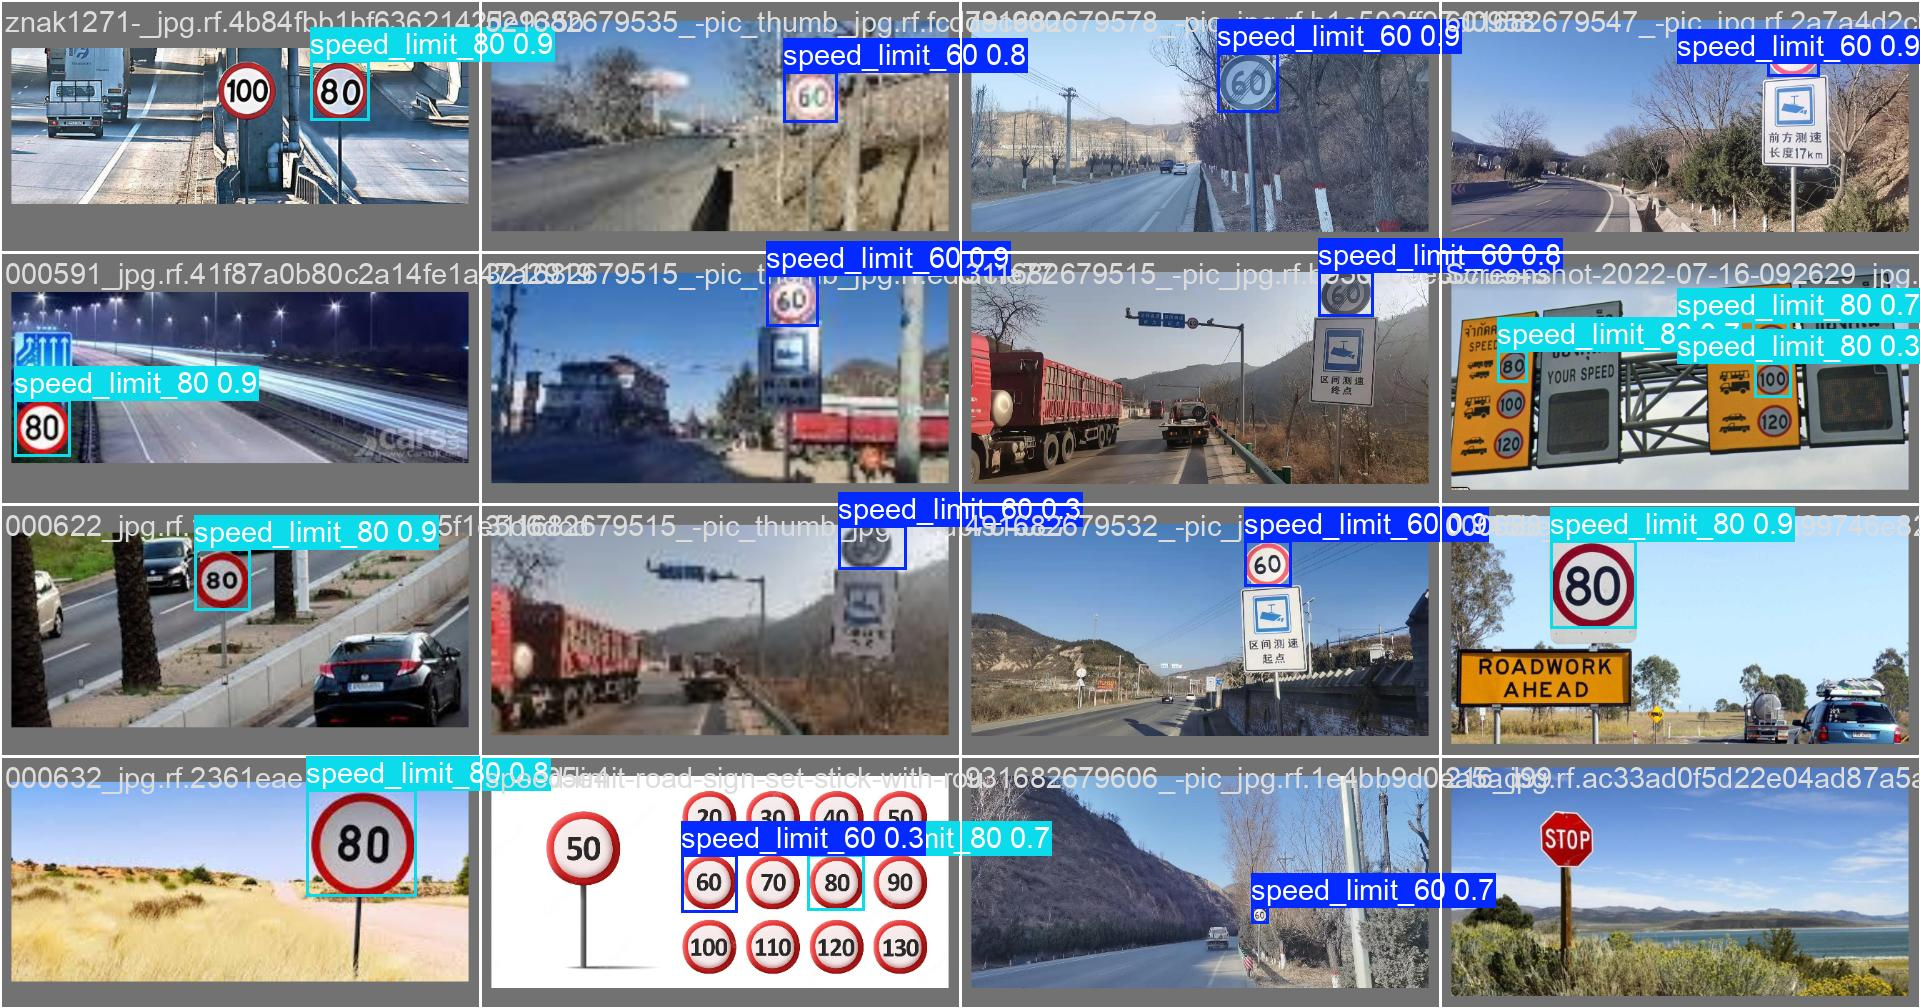

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train32/val_batch0_pred.jpg', width=800)

## Conclusão
Nesse estudo, foi possível ver um pouco sobre o Roboflow e a rede YOLO.

Utilizando as duas ferramentas, consegui encontrar e utilizar um dataset de sinais de trânsito para treinar a rede YOLO v11 de forma bem sucedida.

## Referências
- [Ultralytics YOLO11](https://docs.ultralytics.com/pt/models/yolo11/#overview)
- [How to Train YOLO11 Object Detection on a Custom Dataset](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb)
- [YOLOv11 Architecture](https://medium.com/@nikhil-rao-20/yolov11-explained-next-level-object-detection-with-enhanced-speed-and-accuracy-2dbe2d376f71)